## Q1: Define

### Gaussian Processes (GPs) and Stochastic Processes

- A **stochastic process** is a collection of random variables indexed by time or space. It describes how a system evolves under the influence of randomness.
- A **Gaussian Process (GP)** is a stochastic process where any finite collection of variables has a joint multivariate Gaussian distribution. A GP is fully specified by a **mean function** \( m(x) \) and a **covariance function** or **kernel** \( k(x, x') \).
- GPs are commonly used in regression problems to model distributions over functions and provide a principled, non-parametric Bayesian approach to inference.

### Variational Inference and Evidence Lower Bound (ELBO)

- **Variational Inference (VI)** is a method of approximating complex posterior distributions by a simpler, tractable family of distributions.
- Instead of sampling (like in MCMC), VI turns inference into an optimization problem.
- The **Evidence Lower Bound (ELBO)** is the quantity that VI maximizes. It is a lower bound on the marginal likelihood (evidence) and is given by:

\[
\text{ELBO}(q) = \mathbb{E}_{q(z)}[\log p(x, z)] - \mathbb{E}_{q(z)}[\log q(z)]
\]

- Maximizing the ELBO minimizes the KL divergence between the variational distribution \( q(z) \) and the true posterior \( p(z|x) \).

## Q2: Gaussian Processes in PyMC

Here we demonstrate Gaussian Process regression using PyMC, applied to a synthetic dataset generated from a sinusoidal function with noise.

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 1, 25)[:, None]
Y = np.sin(2 * np.pi * X).ravel() + np.random.normal(0, 0.1, X.shape[0])

# GP model
with pm.Model() as gp_model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfNormal("η", sigma=1)
    
    cov = η ** 2 * pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.Marginal(cov_func=cov)
    
    σ = pm.HalfNormal("σ", sigma=0.1)
    y_ = gp.marginal_likelihood("y", X=X, y=Y, noise=σ)
    
    trace = pm.sample(1000, chains=2)

# Plotting predictions
X_new = np.linspace(0, 1, 100)[:, None]

with gp_model:
    f_pred = gp.conditional("f_pred", X_new)
    pred_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"], return_inferencedata=False)


/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [ℓ, η, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 70 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [f_pred]


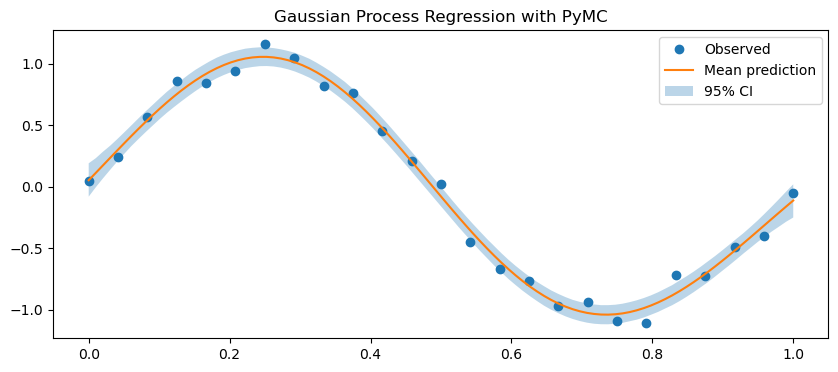

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(X, Y, "o", label="Observed")
plt.plot(X_new, pred_samples["f_pred"].mean(axis=(0, 1)), label="Mean prediction")
plt.fill_between(
    X_new.ravel(),
    np.percentile(pred_samples["f_pred"], 2.5, axis=(0, 1)),
    np.percentile(pred_samples["f_pred"], 97.5, axis=(0, 1)),
    alpha=0.3,
    label="95% CI",
)
plt.legend()
plt.title("Gaussian Process Regression with PyMC")
plt.show()

## Q3: Variational Inference (ELBO) with PyMC on a Neural Network

In this example, we use a small Bayesian neural network and apply automatic variational inference using PyMC's `ADVI` to a regression task.


In [40]:
import pytensor.tensor as pt

# Synthetic dataset
np.random.seed(1)
X = np.linspace(-1, 1, 100)[:, None]
Y = X**3 + np.random.normal(0, 0.1, size=X.shape)

with pm.Model() as nn_model:
    # Priors on weights and biases
    w1 = pm.Normal("w1", 0, 1, shape=(1, 5))
    b1 = pm.Normal("b1", 0, 1, shape=(5,))
    
    w2 = pm.Normal("w2", 0, 1, shape=(5, 1))
    b2 = pm.Normal("b2", 0, 1)
    
    y_hat = pm.Deterministic("y_hat", output)
    
    # Neural network
    hidden = pt.tanh(pt.dot(X, w1) + b1)
    output = pt.dot(hidden, w2) + b2
    
    sigma = pm.HalfNormal("sigma", sigma=0.1)
    y_obs = pm.Normal("y_obs", mu=output, sigma=sigma, observed=Y)

    # Variational Inference
    approx = pm.fit(n=5000, method='advi')
    trace_vi = approx.sample(1000)

Finished [100%]: Average Loss = 940.06


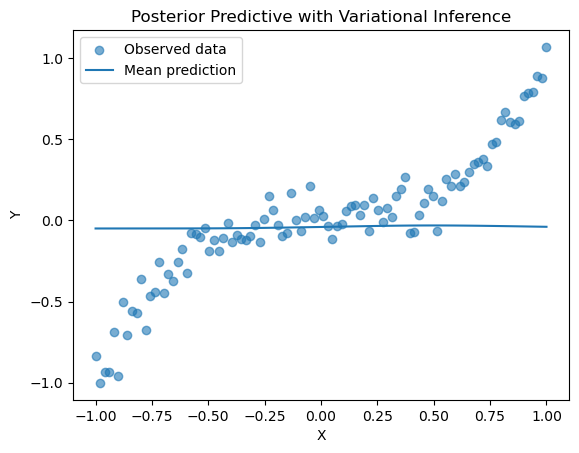

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Extract posterior samples of y_hat from the variational approximation
y_hat_samples = trace_vi.posterior["y_hat"].values  # shape might be (1000, 100, 1) or (1000, 100)

# If there’s a trailing dimension of size 1, squeeze it out:
# (Only do this if y_hat_samples has shape (1000, 100, 1). If it's already (1000,100), skip this.)
if y_hat_samples.ndim == 3:
    y_hat_samples = y_hat_samples.squeeze(-1)  # Now shape is (1000, 100)

# Compute summary statistics across draws
mean_pred = y_hat_samples.mean(axis=(0,1))  
lower = np.percentile(y_hat_samples, 2.5, axis=(0,1))
upper = np.percentile(y_hat_samples, 97.5, axis=(0,1))

# Since X is (100, 1), let's squeeze or ravel it to 1D
X_1d = X.squeeze()

plt.figure()
plt.scatter(X_1d, Y, alpha=0.6, label="Observed data")
plt.plot(X_1d, mean_pred, label="Mean prediction")
plt.legend()
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Posterior Predictive with Variational Inference")
plt.show()